# 사용할 모듈 불러오기

In [194]:
# 사용할 모듈 불러오기 
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder
# 그래프
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 기본
import numpy as np
import pandas as pd
import seaborn as sns
# 함수 사용시 사용
import re
# itertools의 product은 리스트 간의 데카르트 곱을  구하는 데 사용된다.
from itertools import product
# 모델 불러오기
import lightgbm as lgb
from xgboost import XGBRegressor
from xgboost import plot_importance

In [195]:
# 데이터 불러오기
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")
item_categories = pd.read_csv('./data/item_categories.csv')

In [196]:
font_path = "C:/Windows/Fonts/NanumGothic.otf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

In [197]:
# 데이터 프레임 용량 최적화기
def reduce_mem_usage(df, show_result=True):
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # 총 메모리를 Mb단위로 표현해준다. 
    start_mem = df.memory_usage().sum() / 1024**2
    # 각 열별로 데이터 타입 및 최대 최소 값 확인 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in num_types:
            c_min = df[col].min()
            c_max = df[col].max()
            # 만약 정수형이라면 
            if str(col_type)[:3] == 'int':
                # np.iinfo()해당 형이 표현 가능한 최댓값 최솟값을 출력해준다. 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # 만약 실수형이라면
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if show_result: 
        print('Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)'
              .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# EDA

## 결측치 및 데이터 타입 확인

In [198]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [199]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [200]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [201]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [202]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [203]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


- 모든 데이터에 결측치 는 존재하지 않는다.

## 데이터 값 확인

In [204]:
#date_block_num이 각 달을 구간으로 나누어 졌음을 알 수 있다
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [205]:
shops
# 겹치는 이름이 존재한다.

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


- 이름에 특수문자가 들어가고 중복되는 이름들이 보인다

In [206]:
# target value 인 item_cnt_month 가 보이지 않는다
test 

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [207]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [208]:
# 상위카테고리를 생성 할수 있다.
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


- item_category_name에 같은 단어가 들어가는 데이터가 많이 존재한다
- 이를 묶어 더 큰 범주를 만들 수 있다.

## train 이상치 확인

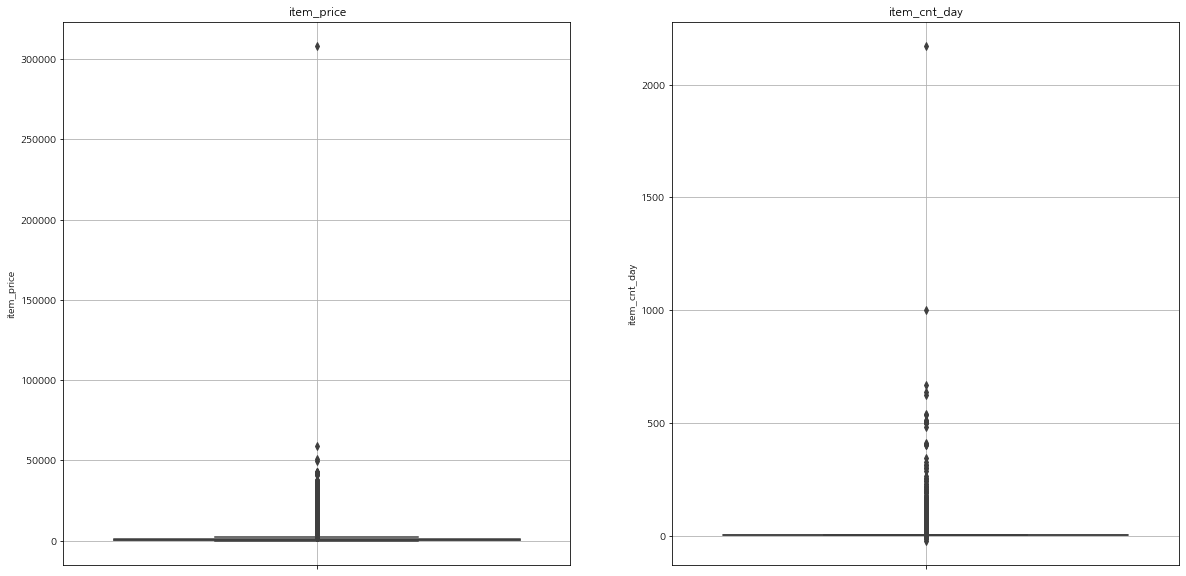

In [209]:
# 달별 박스 플롯 그리기
def price_item_cnt_day_boxplot():
    plt.figure(figsize = (20,10))
    # item_price 의 박스플롯
    plt.subplot(1,2,1)
    sns.boxplot( y= 'item_price',data =train)
    plt.title('item_price')
    plt.grid()
    # item_cnt_day의 박스 플롯
    plt.subplot(1,2,2)
    sns.boxplot(y= 'item_cnt_day',data =train)
    plt.title('item_cnt_day')
    plt.grid()
price_item_cnt_day_boxplot()

- 다음은 date_block_num 별로 item_price의 boxplot이다.  
- 위의 그래프를 기준으로 item_price는 50000 이상 , item_cnt_day 는 1000 이상을 이상치로서 train에서 제거한다.  
- 또한 판매되는 수량을 구하는 것이 목적이므로 0미만의 값을 제거한다.

# 간단한 전처리

## 이상치 제거

In [210]:
# 이상치 제거
condition_for_drop = ((train["item_price"] >= 50000) | (train["item_price"] <= 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

condition_for_drop = ((train["item_cnt_day"] >= 1000) | (train["item_cnt_day"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

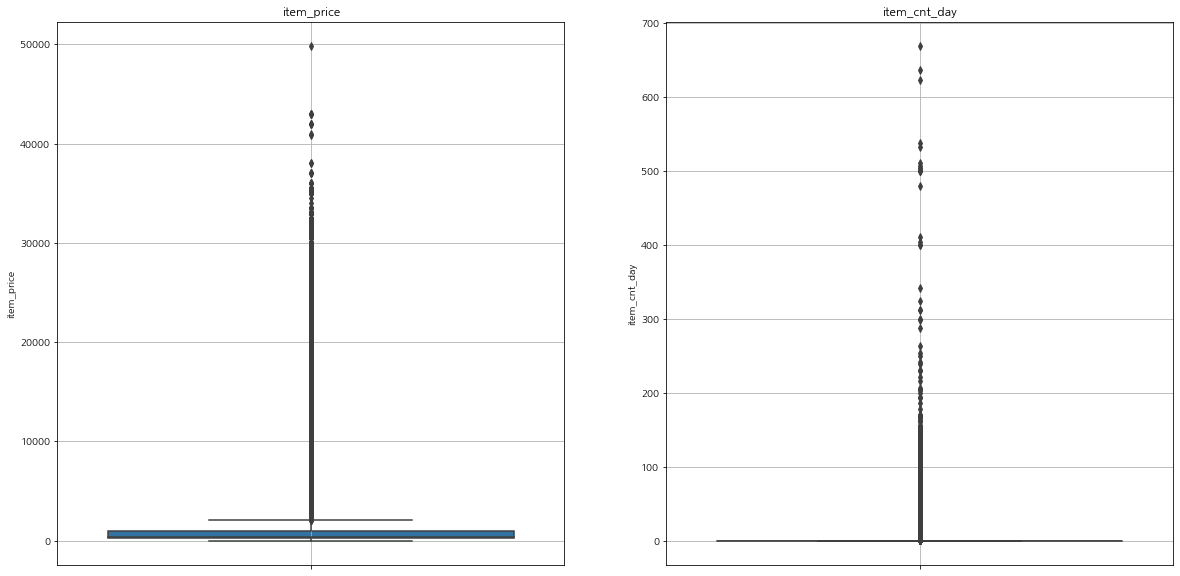

In [211]:
# 제거 후의 boxplot
price_item_cnt_day_boxplot()

## train test 비교

In [212]:
# test의 shop_id , item_id 기 train 데이터에 있는지 확인
diff_train_test_shop_id  = set(train['shop_id']) - set(test['shop_id'])
print('test , train 간의 가지고 있는 고유 shop_id 갯수 차이  : ',len(diff_train_test_shop_id))
diff_test_train_item_id = set(test['item_id']) - set(train['item_id'])
print('test , train 간의 가지고 있는 고유 item_id 갯수 차이: ',len(diff_test_train_item_id))
test_item_id_set = set(test['item_id'])
for data in train['item_id']:
    test_item_id_set.add(data)
diff_test_items_item_id = test_item_id_set - set(items['item_id'])
print('items에 있는  고유 item_id 와 test ,train의 차이: ',len(diff_test_items_item_id))

test , train 간의 가지고 있는 고유 shop_id 갯수 차이  :  18
test , train 간의 가지고 있는 고유 item_id 갯수 차이:  363
items에 있는  고유 item_id 와 test ,train의 차이:  0


- train에만 존재하는 shop_id 가 18개 있음을 알 수 있다
-  train에만 존재하는 item_id  가 363개 있음을 알 수 있다
- items에는 train,test 에 있는 모든 item_id가 있음을 알 수 있다.

# Feature engineering

### shop 하이 카테고리 분리 및 중복 데이터 제거

In [213]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
shops_names = shops["shop_name"].apply(clean_text)
shops_id = shops["shop_id"]
# 중복되는 이름 확인 
for i in list(zip(shops_names ,shops_id)):
    for j in list(zip(shops_names ,shops_id)):
        if (re.match('.*'+i[0]+'*.',j[0])) and (i[1]!= j[1]):
            print('code : ', i[1], ' and  ', j[1])
            print('name : ', i[0], ' and  ', j[0])

code :  10  and   11
name :  Жуковский ул  Чкалова 39м   and   Жуковский ул  Чкалова 39м²
code :  11  and   10
name :  Жуковский ул  Чкалова 39м²  and   Жуковский ул  Чкалова 39м 
code :  39  and   40
name :  РостовНаДону ТРК  Мегацентр Горизонт   and   РостовНаДону ТРК  Мегацентр Горизонт  Островной
code :  57  and   0
name :  Якутск Орджоникидзе  56  and    Якутск Орджоникидзе  56 фран
code :  58  and   1
name :  Якутск ТЦ  Центральный   and    Якутск ТЦ  Центральный  фран


- 위와 같이 shop id가 10:11, 39:40, 57:0, 58:1 4개의 아이디가 중복되는 것을 알 수 있다.
- 위의 데이터를 기준으로 train data의 shop id를 바꾸어준다

In [214]:
train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39} ,inplace =True)
test["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39},inplace =True)
shops["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39},inplace =True)

In [215]:
# item_category 분류하여 새로운 열 만들기
def make_city_category(data_name_col):
    '''
    상위 분류를 생성후 라벨 인코딩을 하는 함수
    shopname 과 item_category_name 에 사용
    '''
    data_name_col = data_name_col.apply(clean_text)
    high_category_name = data_name_col.str.split(' ')
    high_category_name = [data[1] if data[0] == '' else data[0] for data in high_category_name]
    high_category_name_le = LabelEncoder()
    high_category_name_le.fit(high_category_name)
    high_category_id = high_category_name_le.transform(high_category_name)
    return high_category_name , high_category_id

In [216]:
shops['city_name'],shops['city_id'] = make_city_category(shops.shop_name)

In [217]:
shops = shops.drop(['shop_name','city_name'],axis=1).drop_duplicates()

## item 상위 카테고리 , sub 카테고리

In [218]:
item_categories['high_category_name'],item_categories['high_category_id'] = make_city_category(item_categories.item_category_name)


In [219]:
item_categories_value_counts=item_categories['high_category_name'].value_counts()
print(item_categories_value_counts)
item_categories_value_counts = item_categories_value_counts[item_categories['high_category_name'].value_counts()<5].index

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: high_category_name, dtype: int64


In [220]:
item_categories['high_category_name'] = \
item_categories['high_category_name'].apply(lambda x : 'etc' if x in item_categories_value_counts else x)

In [222]:
item_categories['high_category_name'].value_counts()

In [224]:

high_category_name_le = LabelEncoder()
item_categories['high_category_id'] =  high_category_name_le.fit_transform(item_categories['high_category_name'])

In [225]:
def make_sub_cat(df):
    df_temp = df.copy()
    df_temp['split'] = df_temp['item_category_name'].str.split('-')
    df_temp['sub_category'] = df_temp['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
    df_temp['sub_category_id'] = LabelEncoder().fit_transform(df_temp['sub_category'])
    return df_temp['sub_category'] , df_temp['sub_category_id'] 
    

In [226]:
item_categories['sub_category'], item_categories['sub_category_id']   = make_sub_cat(item_categories)

In [227]:
item_categories

,item_category_name,item_category_id,high_category_name,high_category_id,sub_category,sub_category_id
0,PC - Гарнитуры/Наушники,0,etc,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,Аксессуары,1,PSP,13
...,...,...,...,...,...,...
79,Служебные,79,etc,0,Служебные,54
80,Служебные - Билеты,80,etc,0,Билеты,25
81,Чистые носители (шпиль),81,etc,0,Чистые носители (шпиль),62
82,Чистые носители (штучные),82,etc,0,Чистые носители (штучные),63


In [228]:
item_categories.drop(['sub_category','high_category_name','item_category_name'],axis=1,inplace =True)

# Feature Engineering

### 달별 데이터 만들기

In [229]:
'''
itertools 의 product을 사용하여
각 달 아이템이 팔린 가게와 아이템 , data_num_block의 조합을 출력한다. 
'''

sales_df = []
for i in range(34):
    all_shops = train.loc[train['date_block_num'] == i , 'shop_id'].unique()
    all_items = train.loc[train['date_block_num'] == i , 'item_id'].unique()
    sales_df.append(np.array(list(product([i] , all_shops ,all_items))))
base_feature_names = ['date_block_num','shop_id','item_id']
# np.vstack 세로 결합 (열의 갯수가 같아야 한다.)
sales_df = pd.DataFrame(np.vstack(sales_df) , columns = base_feature_names)

In [230]:
'''
doing
item_cnt_day >> item_cnt_month 
'''
train_item_cnt_month  = train.pivot_table(index = base_feature_names ,
                                          values = 'item_cnt_day' , 
                                          aggfunc ={'item_cnt_day': np.sum})
sales_df = pd.merge(sales_df,
                      train_item_cnt_month.reset_index(),
                      on = base_feature_names,
                      how= 'left')

sales_df.rename(columns= {'item_cnt_day':'item_cnt_month'} ,inplace = True)
sales_df['item_cnt_month'] = sales_df['item_cnt_month'].fillna(0).clip(0,20)


In [231]:
sales_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0


## train 에 revenue 추가

In [232]:
train ['item_revenue'] =  train.item_price * train.item_price

## salse_df + test

In [233]:
'''
test에 없는 열을 추가 해야 하거나
train에 쓸모없는 데이터를 제거해야 한다. 
'''
test.columns , sales_df.columns


(Index(['ID', 'shop_id', 'item_id'], dtype='object'),
 Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month'], dtype='object'))

In [234]:
test['date_block_num'] = 34
test = test.set_index('ID')

In [235]:
pd.concat([test,sales_df], ignore_index=True)\
.fillna(0)\
.set_index(base_feature_names)\
.sort_index()\
.reset_index()\
.reset_index()\
.drop('index',axis = 1)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
11026963,34,59,22162,0.0
11026964,34,59,22163,0.0
11026965,34,59,22164,0.0
11026966,34,59,22166,0.0


In [236]:
sales_df =\
pd.concat([test,sales_df], ignore_index=True)\
.fillna(0)\
.set_index(base_feature_names)\
.sort_index()\
.reset_index()\
.reset_index()\
.drop('index',axis = 1)

## merging item , city data

In [237]:
sales_df = \
pd.merge(sales_df ,
         shops ,
         on =  'shop_id')

In [238]:
sales_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city_id
0,0,2,19,0.0,0
1,0,2,27,1.0,0
2,0,2,28,0.0,0


In [239]:

# 처음 팔린 날 저장
items['item_first_sale_date'] = \
train.pivot_table(index = 'item_id' ,
                  values=  'date_block_num' ,
                  aggfunc = np.min)['date_block_num']
items['item_last_sale_date'] = \
train.pivot_table(index = 'item_id' ,
                  values=  'date_block_num' ,
                  aggfunc = np.max)['date_block_num']

# Nan값을 34로 저장 
items['item_first_sale_date'] = items['item_first_sale_date'].fillna(34).astype(np.int)
# train 값에 없으면 test에 존재하기 때문에 
items['item_last_sale_date'] = items['item_last_sale_date'].fillna(34).astype(np.int)

C:\Users\AW17R4\AppData\Local\Temp\ipykernel_8904\404761477.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  items['item_first_sale_date'] = items['item_first_sale_date'].fillna(34).astype(np.int)
C:\Users\AW17R4\AppData\Local\Temp\ipykernel_8904\404761477.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

In [240]:
item_high_categories =\
items.merge(item_categories , on = 'item_category_id').drop('item_name' ,axis =1)

item_high_categories.head(3)

,item_id,item_category_id,item_first_sale_date,item_last_sale_date,high_category_id,sub_category_id
0,0,40,20,20,5,4
1,2,40,19,22,5,4
2,3,40,18,19,5,4


In [241]:
sales_df =\
pd.merge(sales_df ,item_high_categories ,on =  'item_id')

In [242]:
sales_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,item_first_sale_date,item_last_sale_date,high_category_id,sub_category_id
0,0,2,19,0.0,0,40,0,0,5,4
1,0,3,19,0.0,1,40,0,0,5,4
2,0,4,19,0.0,2,40,0,0,5,4


## 날짜 , 달 추가

In [243]:
sales_df['month'] = sales_df.date_block_num % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
sales_df['days'] = sales_df['month'].map(days)

# 시각화

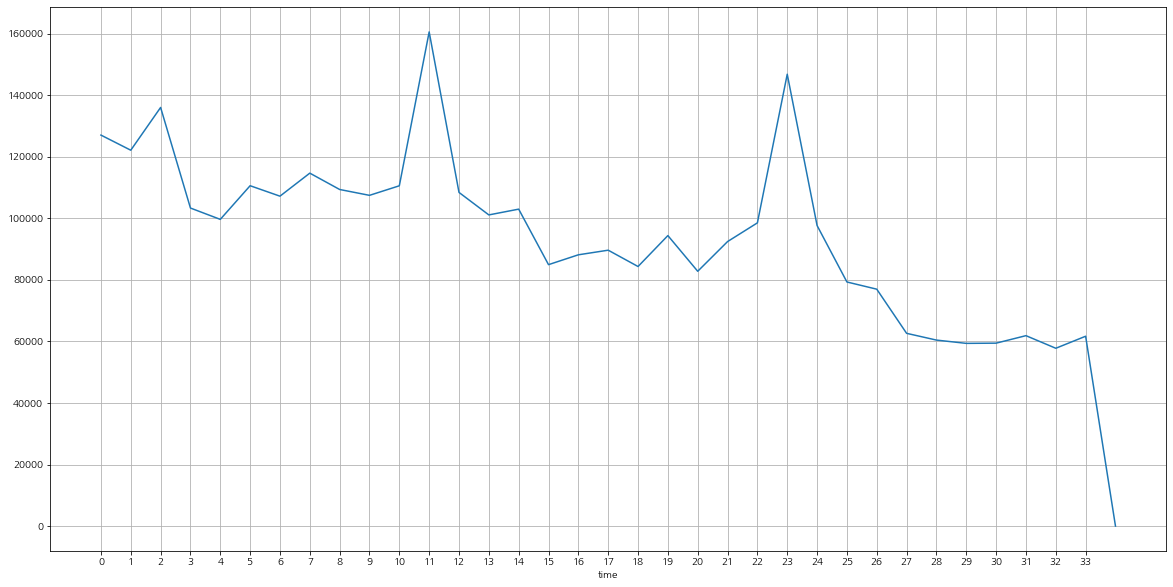

In [244]:
# 월별 item_cnt_day 추이 
pivot = sales_df.pivot_table(index = 'date_block_num' , values = 'item_cnt_month' , aggfunc = np.sum)
plt.figure(figsize=(20,10))
plt.plot(pivot.index, pivot.item_cnt_month)
plt.xlabel('time')
plt.xticks(range(34))
plt.grid()
plt.show()
del pivot

- 날이 갈수록 추세가 감소하는 것을 알 수 있다
- 주기성이 존재한다는 것을 알 수 있다

In [245]:
def draw_x_group_y_sum_barplot(x, y):
    temp_data_for_plot = \
    sales_df.pivot_table(index = x , values = y , aggfunc = np.sum).reset_index()
    plt.figure(figsize=(20,20))
    sns.barplot(x= x,
                y = y, 
                data = temp_data_for_plot)
    plt.title(f'{y}___per___{x}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.rc.fontsize = 20
    plt.show()

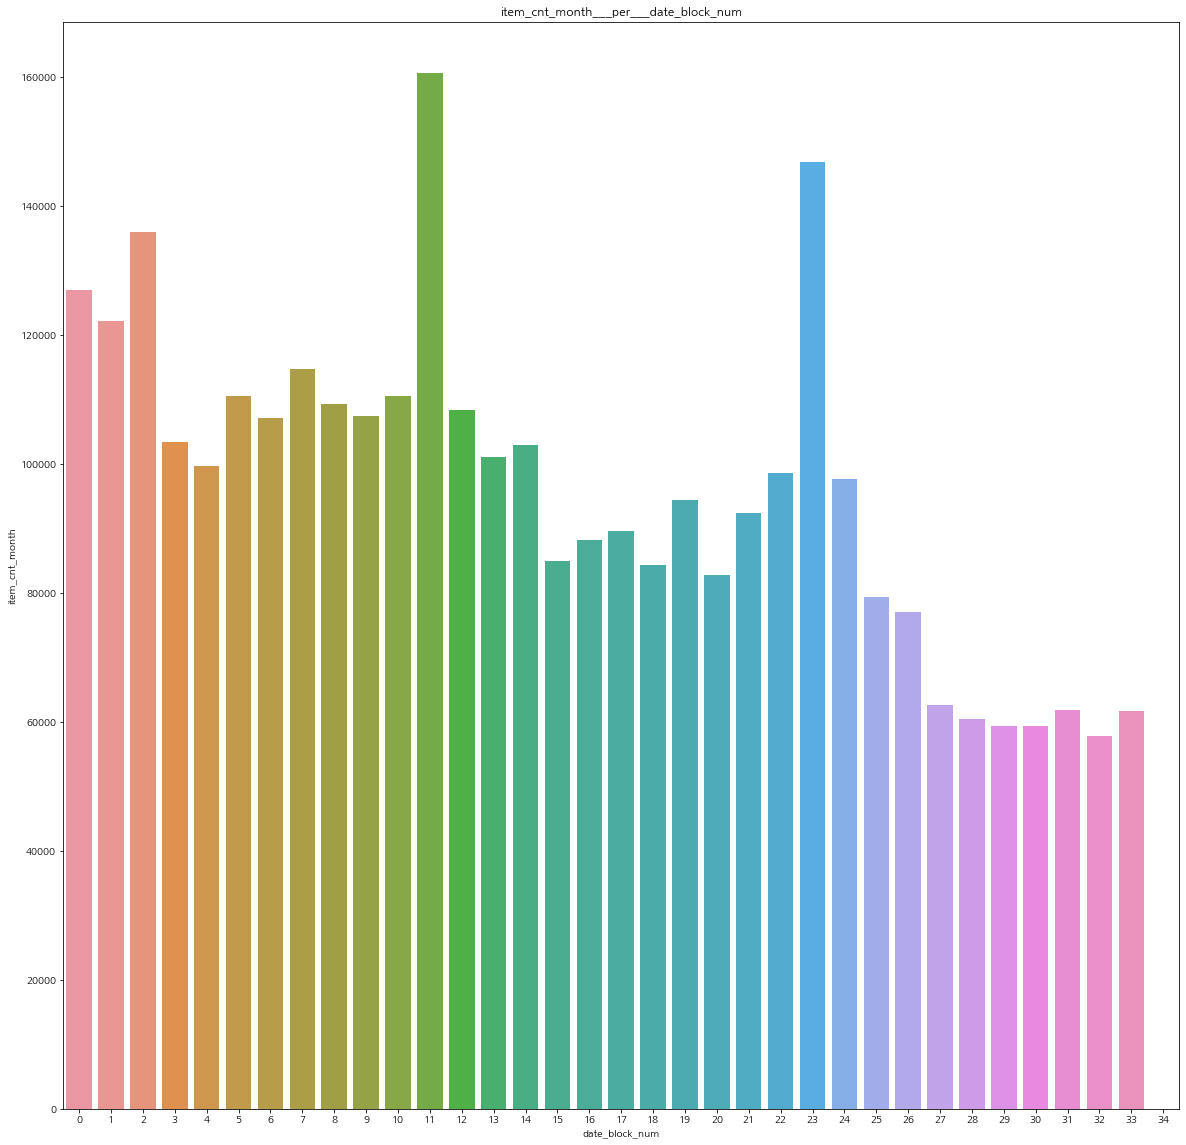

In [246]:
# 달별 item_cnt_month
draw_x_group_y_sum_barplot('date_block_num','item_cnt_month')

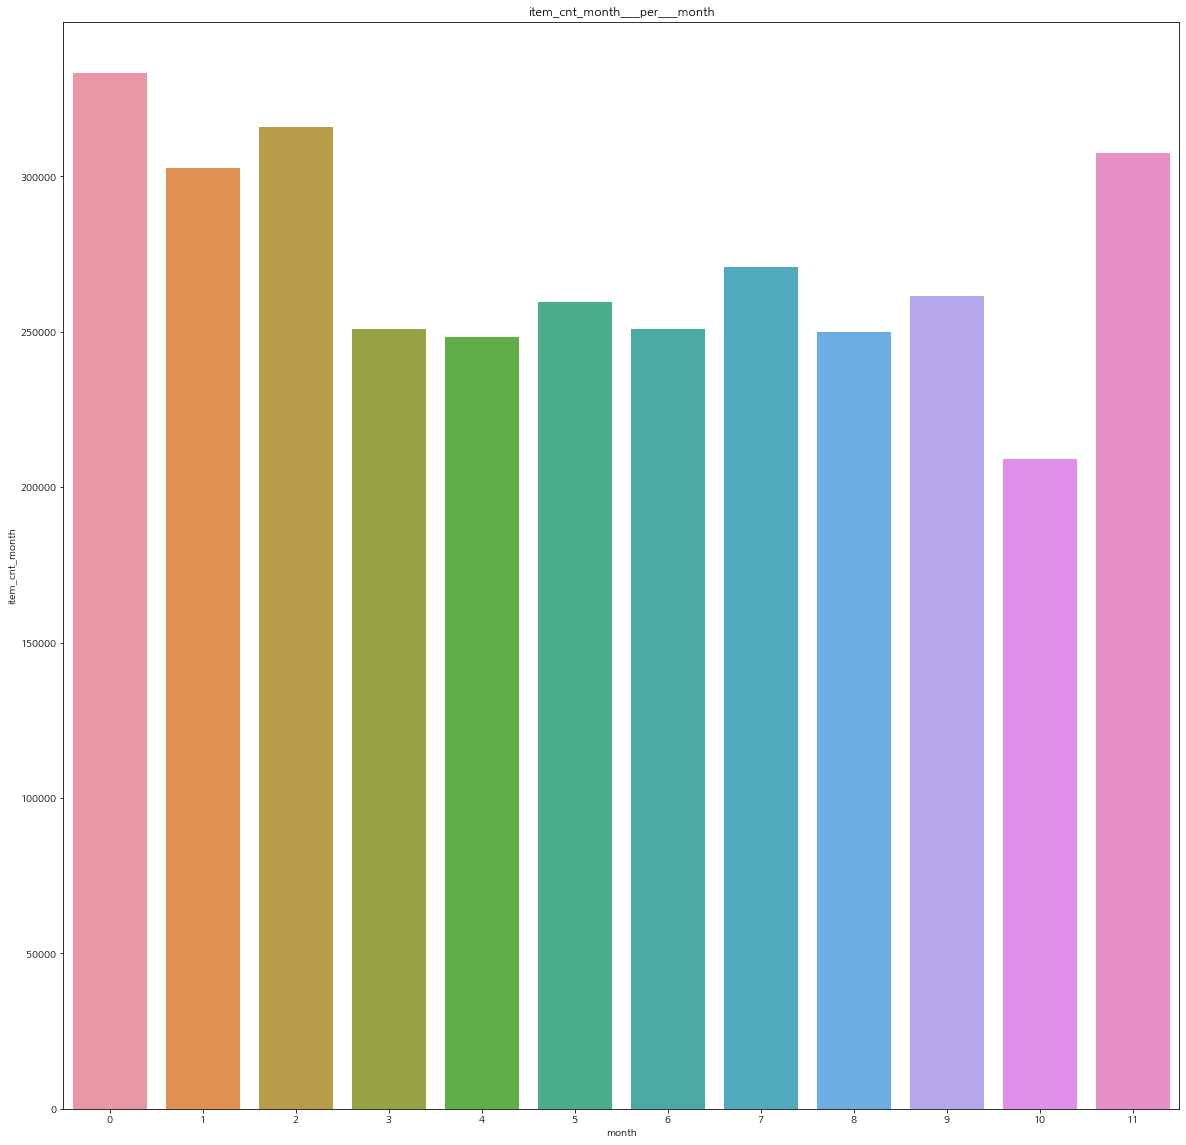

In [247]:
draw_x_group_y_sum_barplot('month','item_cnt_month')

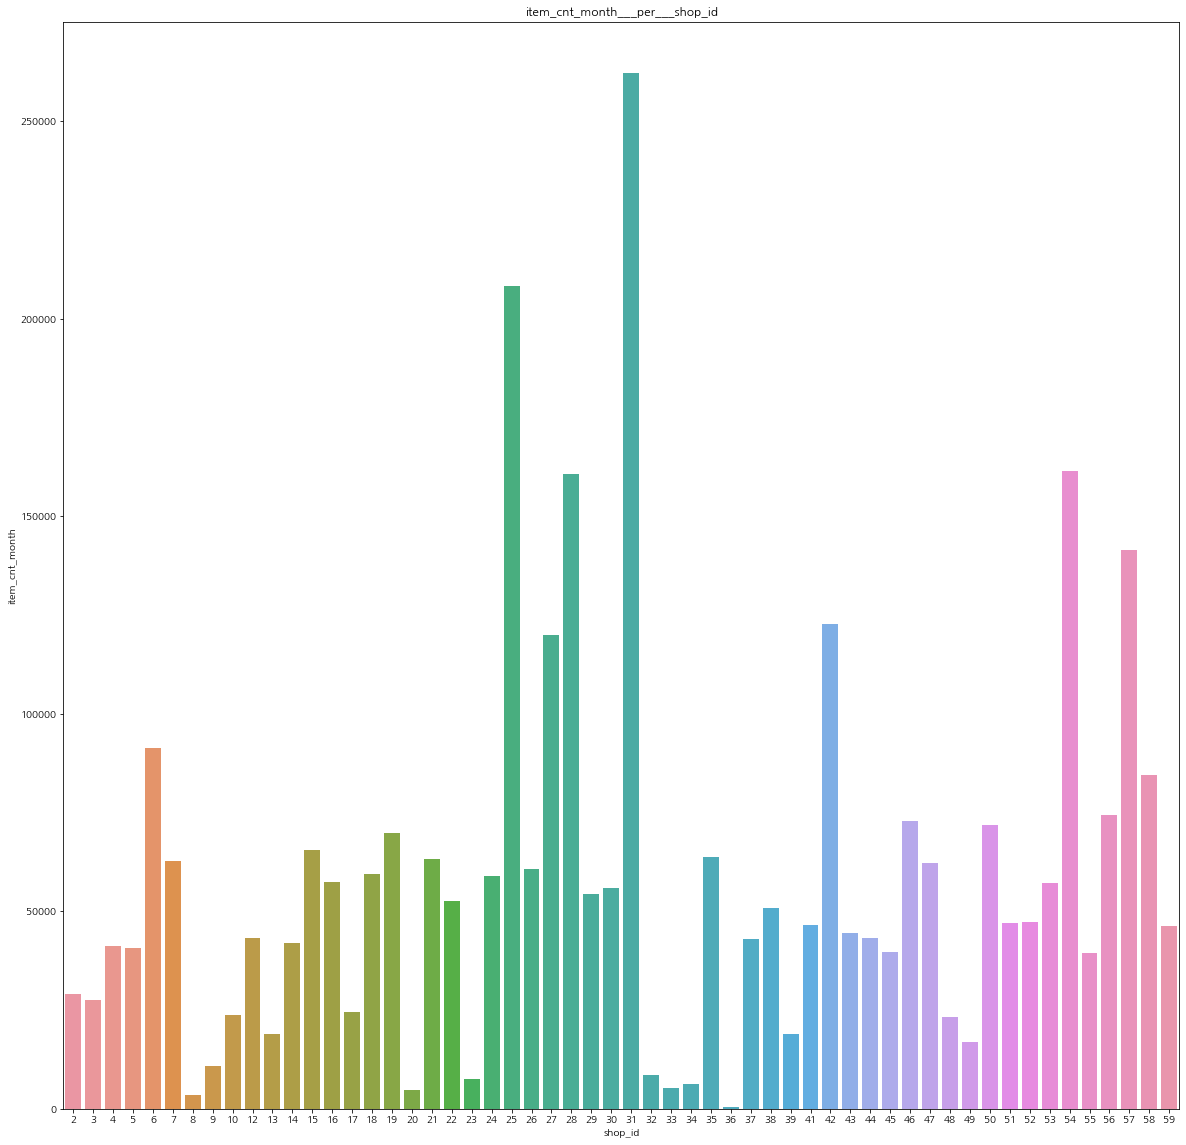

In [248]:
draw_x_group_y_sum_barplot('shop_id','item_cnt_month')

## add mean_feature,lag_feature

In [249]:
def add_mean_feature(df ,
                     base_feature_names ,
                     num_feature_name):
    '''
    base_feature_name를 기준으로 num_feature_name의 값의
    한달 평균을 구해서 df에 병합해주는 함수
    
    df 데이터가 있는 데이터 프레임 
    base_feature_names 기준이 되는 특성이름
    num_feature_name 평균이 구해지는 열이름
    '''
    # 사용에 필요한 데이터만 복사
    df_temp = df[base_feature_names + [num_feature_name]].copy()
    
    # base_feature_names이 너무 많으면 오류를 일으킨다.
    if len(base_feature_names) not in range(1,4):
        raise
    # 새로 생성 되는 feature 의 이름 짓기
    if len(base_feature_names) == 1:
        feature_name = 'date_' +num_feature_name+'_mean'
    elif len(base_feature_names) == 2:
        feature_name = base_feature_names[1] +'_'+num_feature_name.split('_')[1]+ '_month_mean'
    else:
        feature_name = base_feature_names[1] + '_' + base_feature_names[2] +'_'+num_feature_name.split('_')[1]+'_month_mean'
    # num_feature_name >> feature_name 이름 바꾸기
    df_temp = df_temp.rename(columns = {num_feature_name:feature_name})
    print(f'{feature_name}이 생성되었습니다.')
    # base_feature_names을 기준으로 group 지어주고 feature_name의 평균을 구합니다.
    df_temp = df_temp.groupby(base_feature_names).agg({feature_name : np.mean}).reset_index()
    df = df.merge(df_temp ,
                  on =base_feature_names,
                  how= 'left') 
    # df 와 feature_name을 반환하여 바로 add_lag_data을 돌릴수 있도록 합니다.
    return df , feature_name

In [250]:
def add_lag_data(df ,lag_feature, lag_periods= [1] , drop = True):
    '''
    lag_period 만큼의 시차 데이터를 생성하는 함수
    df 데이터가 있는 데이터 프레임  
    lag_feature 시차데이터가 생성될 열의 이름  
    lag_periods= [1]  lag_periods 시차데이터를 얼마나 생성할지 정함
    drop = True  시차 데이터를 생성 후 원래의 데이터 제거 여부
    '''
    # 기준이 되는 특성이름 리스트
    base_feature_names = ['date_block_num','shop_id','item_id']
    # lag_periods값만 큼 시차 데이터를 생성한다. 
    for i in lag_periods:
        # 필요한 데이터만 임시로 저장
        df_temp = df[base_feature_names + [lag_feature]].copy()
        # 생성되는 특성이름 
        feature_name  = lag_feature +"_lag_"+str(i)
        # 생성되는 특성이름 적용
        df_temp.columns = base_feature_names +[feature_name]
        # date_block_num 값에 전체적으로 1값을 더하면서 shift를 한 것처럼 한다.
        df_temp['date_block_num'] +=i
        df = df.merge(df_temp, 
                      on=base_feature_names, 
                      how='left')
        # nan값을 0으로 채원준다.
        df[feature_name] = df[feature_name].fillna(0)
        print(f'{feature_name}을 생성하였습니다.')
        # 만약 drop =True 이면 lag_feature를 drop한다. 
    if drop : 
        df = df.drop(columns = [lag_feature] ,axis =1)
    
    return df 

## target_value

In [251]:
# 월별 item_cnt_month의 시차데이터 생성 
sales_df =\
add_lag_data(sales_df,
            'item_cnt_month',
            [1,2,3,6,12],
            False)

item_cnt_month_lag_1을 생성하였습니다.
item_cnt_month_lag_2을 생성하였습니다.
item_cnt_month_lag_3을 생성하였습니다.
item_cnt_month_lag_6을 생성하였습니다.
item_cnt_month_lag_12을 생성하였습니다.


## date_block_num

In [252]:
# 월별 아이템 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','item_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df  =\
add_lag_data(sales_df,
            num_feature_name,
            [1,2,3,6,12])

item_id_cnt_month_mean이 생성되었습니다.
item_id_cnt_month_mean_lag_1을 생성하였습니다.
item_id_cnt_month_mean_lag_2을 생성하였습니다.
item_id_cnt_month_mean_lag_3을 생성하였습니다.
item_id_cnt_month_mean_lag_6을 생성하였습니다.
item_id_cnt_month_mean_lag_12을 생성하였습니다.


In [253]:
# 월별 아이템 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','high_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df =\
add_lag_data(sales_df,
            num_feature_name,
            [1])

high_category_id_cnt_month_mean이 생성되었습니다.
high_category_id_cnt_month_mean_lag_1을 생성하였습니다.


In [254]:
# 월별 카테고리별 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','item_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df=\
add_lag_data(sales_df,
            num_feature_name,
            [1])

item_category_id_cnt_month_mean이 생성되었습니다.
item_category_id_cnt_month_mean_lag_1을 생성하였습니다.


In [255]:
# 월별 가게당 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','shop_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df  =\
add_lag_data(sales_df,
            num_feature_name,
            [1,2,3,6,12])

shop_id_cnt_month_mean이 생성되었습니다.
shop_id_cnt_month_mean_lag_1을 생성하였습니다.
shop_id_cnt_month_mean_lag_2을 생성하였습니다.
shop_id_cnt_month_mean_lag_3을 생성하였습니다.
shop_id_cnt_month_mean_lag_6을 생성하였습니다.
shop_id_cnt_month_mean_lag_12을 생성하였습니다.


In [256]:
# 월별 도시당 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','city_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df  =\
add_lag_data(sales_df,
            num_feature_name,
            [1])

city_id_cnt_month_mean이 생성되었습니다.
city_id_cnt_month_mean_lag_1을 생성하였습니다.


In [257]:
# 월별 서브 카테고리 볗 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','sub_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df  =\
add_lag_data(sales_df,
            num_feature_name,
            [1])

sub_category_id_cnt_month_mean이 생성되었습니다.
sub_category_id_cnt_month_mean_lag_1을 생성하였습니다.


### date_block_num shop_id

In [258]:
# 월별 가게에서 카테고리 별로 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','shop_id','item_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df =\
add_lag_data(sales_df,
            num_feature_name,
            [1])

shop_id_item_category_id_cnt_month_mean이 생성되었습니다.
shop_id_item_category_id_cnt_month_mean_lag_1을 생성하였습니다.


In [259]:
# 월별 가게에서 하이 카테고리 별로 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','shop_id','high_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df  =\
add_lag_data(sales_df,
            num_feature_name,
            [1])

shop_id_high_category_id_cnt_month_mean이 생성되었습니다.
shop_id_high_category_id_cnt_month_mean_lag_1을 생성하였습니다.


In [260]:
# 월별 가게에서 서브 카테고리 별로 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','shop_id','sub_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df  =\
add_lag_data(sales_df,
            num_feature_name,
            [1])

shop_id_sub_category_id_cnt_month_mean이 생성되었습니다.
shop_id_sub_category_id_cnt_month_mean_lag_1을 생성하였습니다.


### date_block_num item_id

In [261]:
# 월별 도시에서 아이템 별로 팔린 아이템 갯수의 평균 
base_feature_names = ['date_block_num','item_id','city_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df  =\
add_lag_data(sales_df,
            num_feature_name,
            [1])

item_id_city_id_cnt_month_mean이 생성되었습니다.
item_id_city_id_cnt_month_mean_lag_1을 생성하였습니다.


In [262]:
sales_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_id',
       'item_category_id', 'item_first_sale_date', 'item_last_sale_date',
       'high_category_id', 'sub_category_id', 'month', 'days',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'item_id_cnt_month_mean_lag_1', 'item_id_cnt_month_mean_lag_2',
       'item_id_cnt_month_mean_lag_3', 'item_id_cnt_month_mean_lag_6',
       'item_id_cnt_month_mean_lag_12',
       'high_category_id_cnt_month_mean_lag_1',
       'item_category_id_cnt_month_mean_lag_1', 'shop_id_cnt_month_mean_lag_1',
       'shop_id_cnt_month_mean_lag_2', 'shop_id_cnt_month_mean_lag_3',
       'shop_id_cnt_month_mean_lag_6', 'shop_id_cnt_month_mean_lag_12',
       'city_id_cnt_month_mean_lag_1', 'sub_category_id_cnt_month_mean_lag_1',
       'shop_id_item_category_id_cnt_month_mean_lag_1',
       'shop_id_high_category_id_cnt_month_mean_lag_1',
       '

In [263]:
sales_df_backup = sales_df.copy()
sales_df = reduce_mem_usage(sales_df)

Mem. usage decreased to 715.10 Mb (74.6% reduction)


## add_trend_data

### add item price delta

In [264]:
'''
아이템 별 가격 평균을 구해서 sales_df에 마징
'''
base_feature_names = ['item_id']

train_price  = train.pivot_table(index = base_feature_names ,
                                          values = 'item_price' , 
                                          aggfunc = np.mean)
sales_df = pd.merge(sales_df,
                      train_price.reset_index(),
                      on = base_feature_names,
                      how= 'left')


sales_df.rename(columns= {'item_price':'item_price_mean'} 
                  ,inplace = True)

In [265]:
'''
달별 아이템의 가격 평균 구하기
구하고 마징
'''
base_feature_names = ['date_block_num','item_id']
num_feature_name = 'item_price'

train_pivot = train.pivot_table(index = base_feature_names,values =num_feature_name )
train_pivot.columns = ['item_price_mean_month']
train_pivot.reset_index(inplace=True)
delete_feature_names =  ['item_price_mean_month']

In [266]:
sales_df = pd.merge(sales_df, train_pivot, on=base_feature_names, how='left')

In [267]:
'''
달별 아이템의 가격 평균의 시차 데이터 구하기
'''
lags = [1,2,3,4,5,6]
sales_df= \
add_lag_data(sales_df,
             'item_price_mean_month',
            lags , 
            False)
delete_feature_names += list(sales_df.columns[-6:])

item_price_mean_month_lag_1을 생성하였습니다.
item_price_mean_month_lag_2을 생성하였습니다.
item_price_mean_month_lag_3을 생성하였습니다.
item_price_mean_month_lag_4을 생성하였습니다.
item_price_mean_month_lag_5을 생성하였습니다.
item_price_mean_month_lag_6을 생성하였습니다.


In [268]:
'''
각 lag 별 델타 만들기
'''
for i in lags:
    delete_feature_names.append('delta_price_lag'+str(i))
    sales_df['delta_price_lag'+str(i)] = \
        (sales_df['item_price_mean_month_lag_'+str(i)] - sales_df['item_price_mean']) / sales_df['item_price_mean']

In [269]:
delete_feature_names+=['item_price_mean']

In [270]:
'''
apply 로 사용하여 delta_price_lag 별 0이 아닌 값을 선택한다.
'''
def choice_not_zero_delta (delta_lag):
    for i in range(1,7):
        if  delta_lag['delta_price_lag'+str(i)] != 0:
            return delta_lag['delta_price_lag'+str(i)]
    return 0

In [271]:
'''
apply 적용 후 nan값을 0으로 채워 준다. 
'''
sales_df['delta_price_lag'] = sales_df.apply(choice_not_zero_delta, axis=1)
sales_df['delta_price_lag'].fillna(0, inplace=True)

In [272]:
'''
지워야 할값을 제거 한다.
'''
sales_df.drop(delete_feature_names , axis =1 , inplace =True)

In [273]:
sales_df_backup = sales_df.copy()
sales_df = reduce_mem_usage(sales_df)

Mem. usage decreased to 736.13 Mb (7.9% reduction)


In [274]:
sales_df = sales_df_backup.copy()

### add shop revenue

In [275]:
'''
위와 같은 작업을 반복해준다.
'''
base_feature_names = ['date_block_num' ,'shop_id']
train_revenue = train.pivot_table(index = base_feature_names ,
                                          values = 'item_revenue' , 
                                          aggfunc = np.sum)
sales_df = pd.merge(sales_df,
                      train_revenue.reset_index(),
                      on = base_feature_names,
                      how= 'left')
sales_df.rename(columns= {'item_revenue':'shop_revenue_month_sum'} 
                  ,inplace = True)

In [276]:
'''

'''
base_feature_names = ['shop_id']
num_feature_name = 'item_revenue'
train_pivot = train.pivot_table(index = base_feature_names,values =num_feature_name )
train_pivot.columns = ['shop_revenue_mean']
train_pivot.reset_index(inplace=True)
delete_feature_names =  ['shop_revenue_mean']

In [277]:
sales_df = pd.merge(sales_df, train_pivot, on=base_feature_names, how='left')

In [278]:
delete_feature_names +=  ['shop_revenue_month_sum']

In [279]:
lags = [1,2,3,4,5,6]
sales_df= \
add_lag_data(sales_df,
             'shop_revenue_month_sum',
            lags , 
            False)
delete_feature_names += list(sales_df.columns[-6:])

shop_revenue_month_sum_lag_1을 생성하였습니다.
shop_revenue_month_sum_lag_2을 생성하였습니다.
shop_revenue_month_sum_lag_3을 생성하였습니다.
shop_revenue_month_sum_lag_4을 생성하였습니다.
shop_revenue_month_sum_lag_5을 생성하였습니다.
shop_revenue_month_sum_lag_6을 생성하였습니다.


In [280]:
# 각 lag 별 델타 만들기
for i in lags:
    delete_feature_names.append('delta_revenue_lag'+str(i))
    sales_df['delta_revenue_lag'+str(i)] = \
        (sales_df['shop_revenue_month_sum_lag_'+str(i)] - sales_df['shop_revenue_mean']) / sales_df['shop_revenue_mean']

In [281]:
def choice_not_zero_delta (delta_lag):
    for i in range(1,7):
        delta_lag['delta_revenue_lag'+str(i)]
        if  delta_lag['delta_revenue_lag'+str(i)] != 0:
            return delta_lag['delta_revenue_lag'+str(i)]
    return 0

In [282]:
sales_df['delta_revenue_lag'] = sales_df.apply(choice_not_zero_delta, axis=1)
sales_df['delta_revenue_lag'].fillna(0, inplace=True)

In [283]:
sales_df.drop(delete_feature_names , axis =1 , inplace =True)

In [284]:
sales_df['delta_revenue_lag'].unique()

array([-1.00000000e+00,  6.30738738e+02,  2.25354010e+02, ...,
        1.15933531e+03,  2.22946946e+02,  3.02000000e+02])

In [285]:
sales_df_backup = sales_df.copy()
sales_df = reduce_mem_usage(sales_df)

Mem. usage decreased to 757.16 Mb (14.3% reduction)


In [286]:
sales_df = sales_df_backup.copy()
sales_df = reduce_mem_usage(sales_df)

Mem. usage decreased to 757.16 Mb (14.3% reduction)


## 기타

In [287]:
# 아이템이 새로 발매된 날
sales_df['item_new'] = (sales_df['item_first_sale_date'] == sales_df['date_block_num'])
# 아이템이 다음에 팔리 때 까지 걸리는 시간
sales_df['duration_date'] = \
sales_df['date_block_num'] - sales_df['item_first_sale_date']
# 아이템이 마지막으로 판린날 
sales_df['item_end'] = (sales_df['item_last_sale_date'] == sales_df['date_block_num'])
# 아이템이 처음으로 가게에 팔린날
sales_df['item_shop_first_sale'] = \
sales_df['date_block_num'] - sales_df.groupby(['item_id','shop_id'])['date_block_num'].transform('min') 
# 아이템이 가게 별로 마지막에 팔린날
sales_df['item_shop_last_sale'] = \
sales_df['date_block_num'] - sales_df.groupby(['item_id','shop_id'])['date_block_num'].transform('max') 




C:\Users\AW17R4\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\AW17R4\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


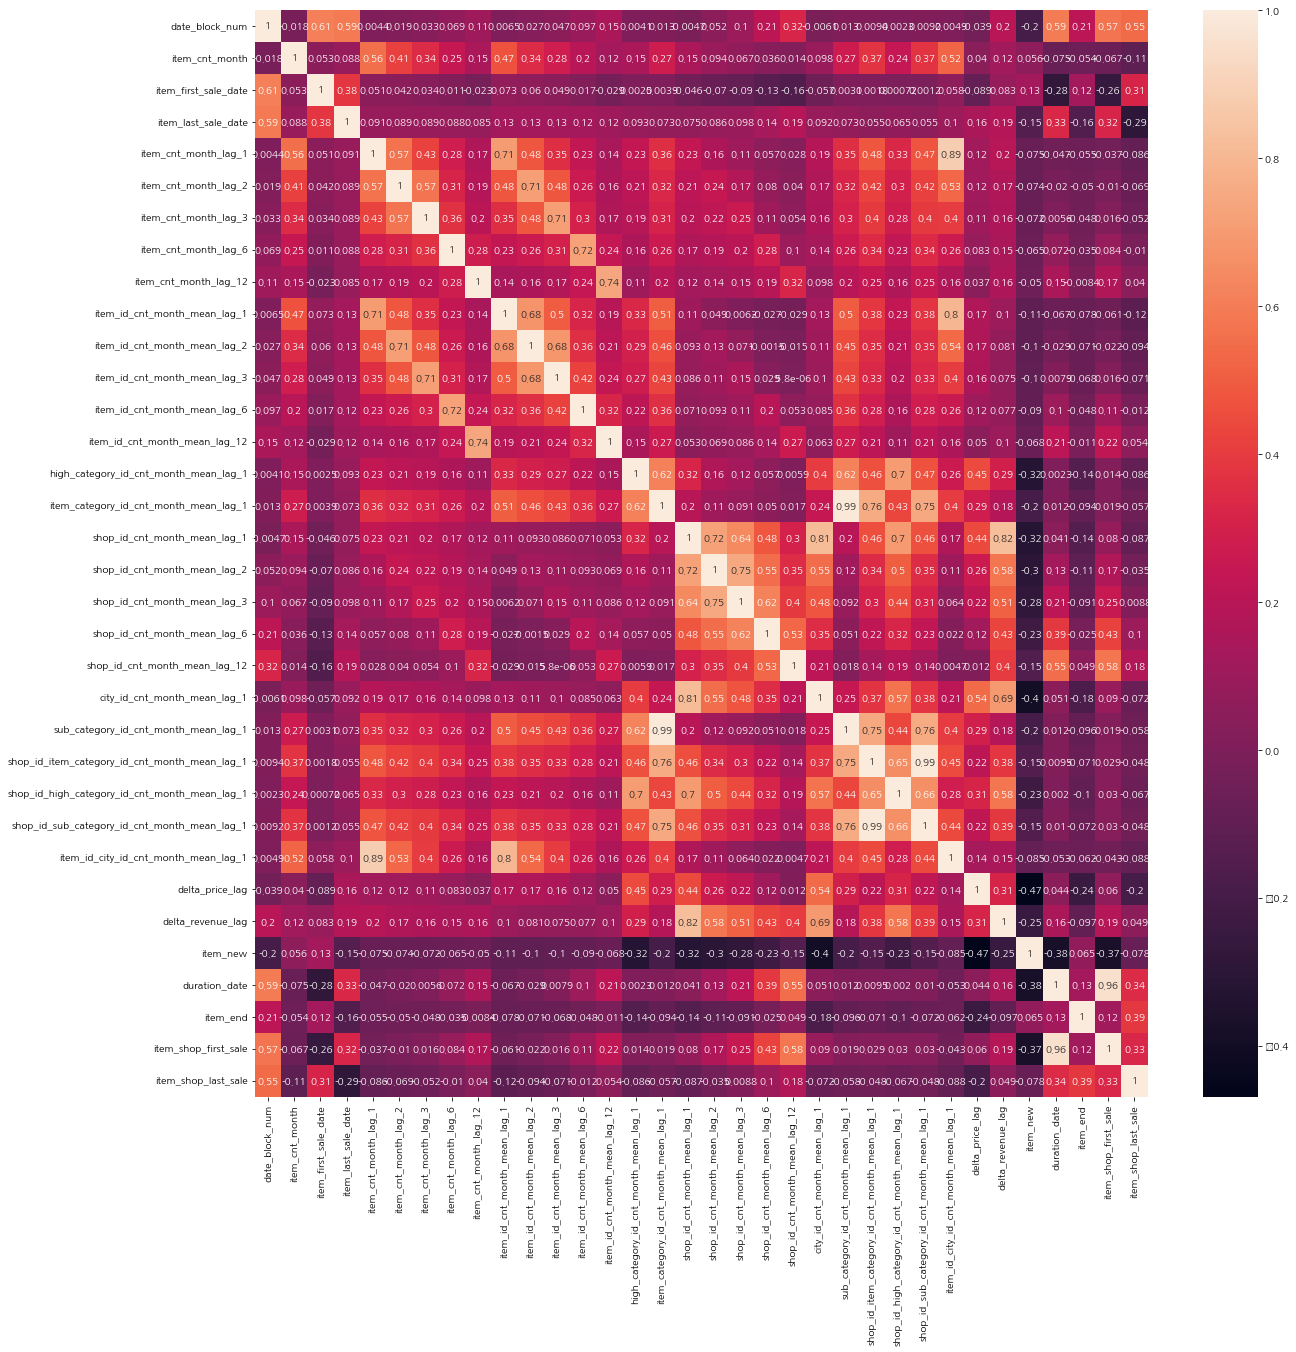

In [288]:
'''

'''
catagory_feature_names = ['shop_id',
                          'city_id',
                          'item_category_id',
                          'high_category_id', 
                          'sub_category_id',
                          'month',
                          'days',
                          'item_id']
sales_corr = sales_df.drop(columns = catagory_feature_names).corr() 
plt.figure(figsize=(20,20))
sns.heatmap(sales_corr, annot=True)
plt.show()

def find_high_corr_location(df_corr , threshold = 0.9):
    cols = df_corr.columns
    high_corr_location = []
    for col in cols :
        for index in cols:
            df_corr_data = [index,col,df_corr.loc[index,col]]
            df_corr_data_2 = [col,index,df_corr.loc[col,index]]
            if (df_corr_data[2] >threshold ) &  (index != col) &(df_corr_data_2 not in high_corr_location):
                high_corr_location.append(df_corr_data)
                print(f'{df_corr_data[0]}와{df_corr_data[1]}는 {df_corr_data[2]}의 상관계수를 가집니다.\n')

In [289]:
find_high_corr_location(sales_corr ,0.8)

item_id_city_id_cnt_month_mean_lag_1와item_cnt_month_lag_1는 0.8850484108369545의 상관계수를 가집니다.

sub_category_id_cnt_month_mean_lag_1와item_category_id_cnt_month_mean_lag_1는 0.9858713450876634의 상관계수를 가집니다.

city_id_cnt_month_mean_lag_1와shop_id_cnt_month_mean_lag_1는 0.8110500191734332의 상관계수를 가집니다.

delta_revenue_lag와shop_id_cnt_month_mean_lag_1는 0.8237158643690906의 상관계수를 가집니다.

shop_id_sub_category_id_cnt_month_mean_lag_1와shop_id_item_category_id_cnt_month_mean_lag_1는 0.9856657450481676의 상관계수를 가집니다.

item_shop_first_sale와duration_date는 0.955337371655036의 상관계수를 가집니다.



In [290]:
sales_df  =sales_df.drop(['item_id_city_id_cnt_month_mean_lag_1'
               ,'city_id_cnt_month_mean_lag_1',
               'sub_category_id_cnt_month_mean_lag_1',
               'shop_id_cnt_month_mean_lag_1',
              'shop_id_sub_category_id_cnt_month_mean_lag_1',
                'duration_date'] , axis=1)

In [291]:
# 1년 시차 데이터 가 저장되어 있기 때문에 처음 1년을 뺀다.
sales_df = sales_df[sales_df.date_block_num>11]

In [292]:
## model 에 시계열 데이터를 훈련시켰을 때 가장 가까운 시간대의 예측 정확도가  높다 
## 그러므로 다음과 같이 나누어 주었다. 

In [293]:

x_train = sales_df[sales_df['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis = 1)
y_train = sales_df[sales_df['date_block_num'] < 33]['item_cnt_month']


x_valid = sales_df[sales_df['date_block_num'] == 33]
x_valid = x_valid.drop(['item_cnt_month'], axis = 1)
y_valid = sales_df[sales_df['date_block_num'] == 33]['item_cnt_month']

x_test = sales_df[sales_df['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis = 1)
y_test = sales_df[sales_df['date_block_num'] == 34]['item_cnt_month']

In [302]:


catagory_feature_names = ['shop_id',
                          'city_id',
                          'item_category_id',
                          'high_category_id', 
                          'sub_category_id',
                          'month',
                          'item_id']

params = {'metric': 'rmse',
          'num_leaves': 600,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_valid, y_valid)
 

lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=5000,
                      valid_sets=(dtrain, dvalid),
                      categorical_feature=catagory_feature_names,
                      early_stopping_rounds=150,
                      verbose_eval=100)     

[LightGBM] [Info] Total Bins 17810
[LightGBM] [Info] Number of data points in the train set: 6095840, number of used features: 35
[LightGBM] [Info] Start training from score 0.293706
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.946542	valid_1's rmse: 1.00073
[200]	training's rmse: 0.814043	valid_1's rmse: 0.943298
[300]	training's rmse: 0.737754	valid_1's rmse: 0.922769
[400]	training's rmse: 0.694354	valid_1's rmse: 0.91442
[500]	training's rmse: 0.666465	valid_1's rmse: 0.911155
[600]	training's rmse: 0.647874	valid_1's rmse: 0.910306
[700]	training's rmse: 0.633966	valid_1's rmse: 0.910096
[800]	training's rmse: 0.622282	valid_1's rmse: 0.911155
Early stopping, best iteration is:
[681]	training's rmse: 0.636409	valid_1's rmse: 0.909793


In [303]:
preds = lgb_model.predict(x_test).clip(0,20)
submission = pd.DataFrame({
    "ID": test.index, 
    
    "item_cnt_month": preds
})
submission.to_csv('submission.csv', index=False)  

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

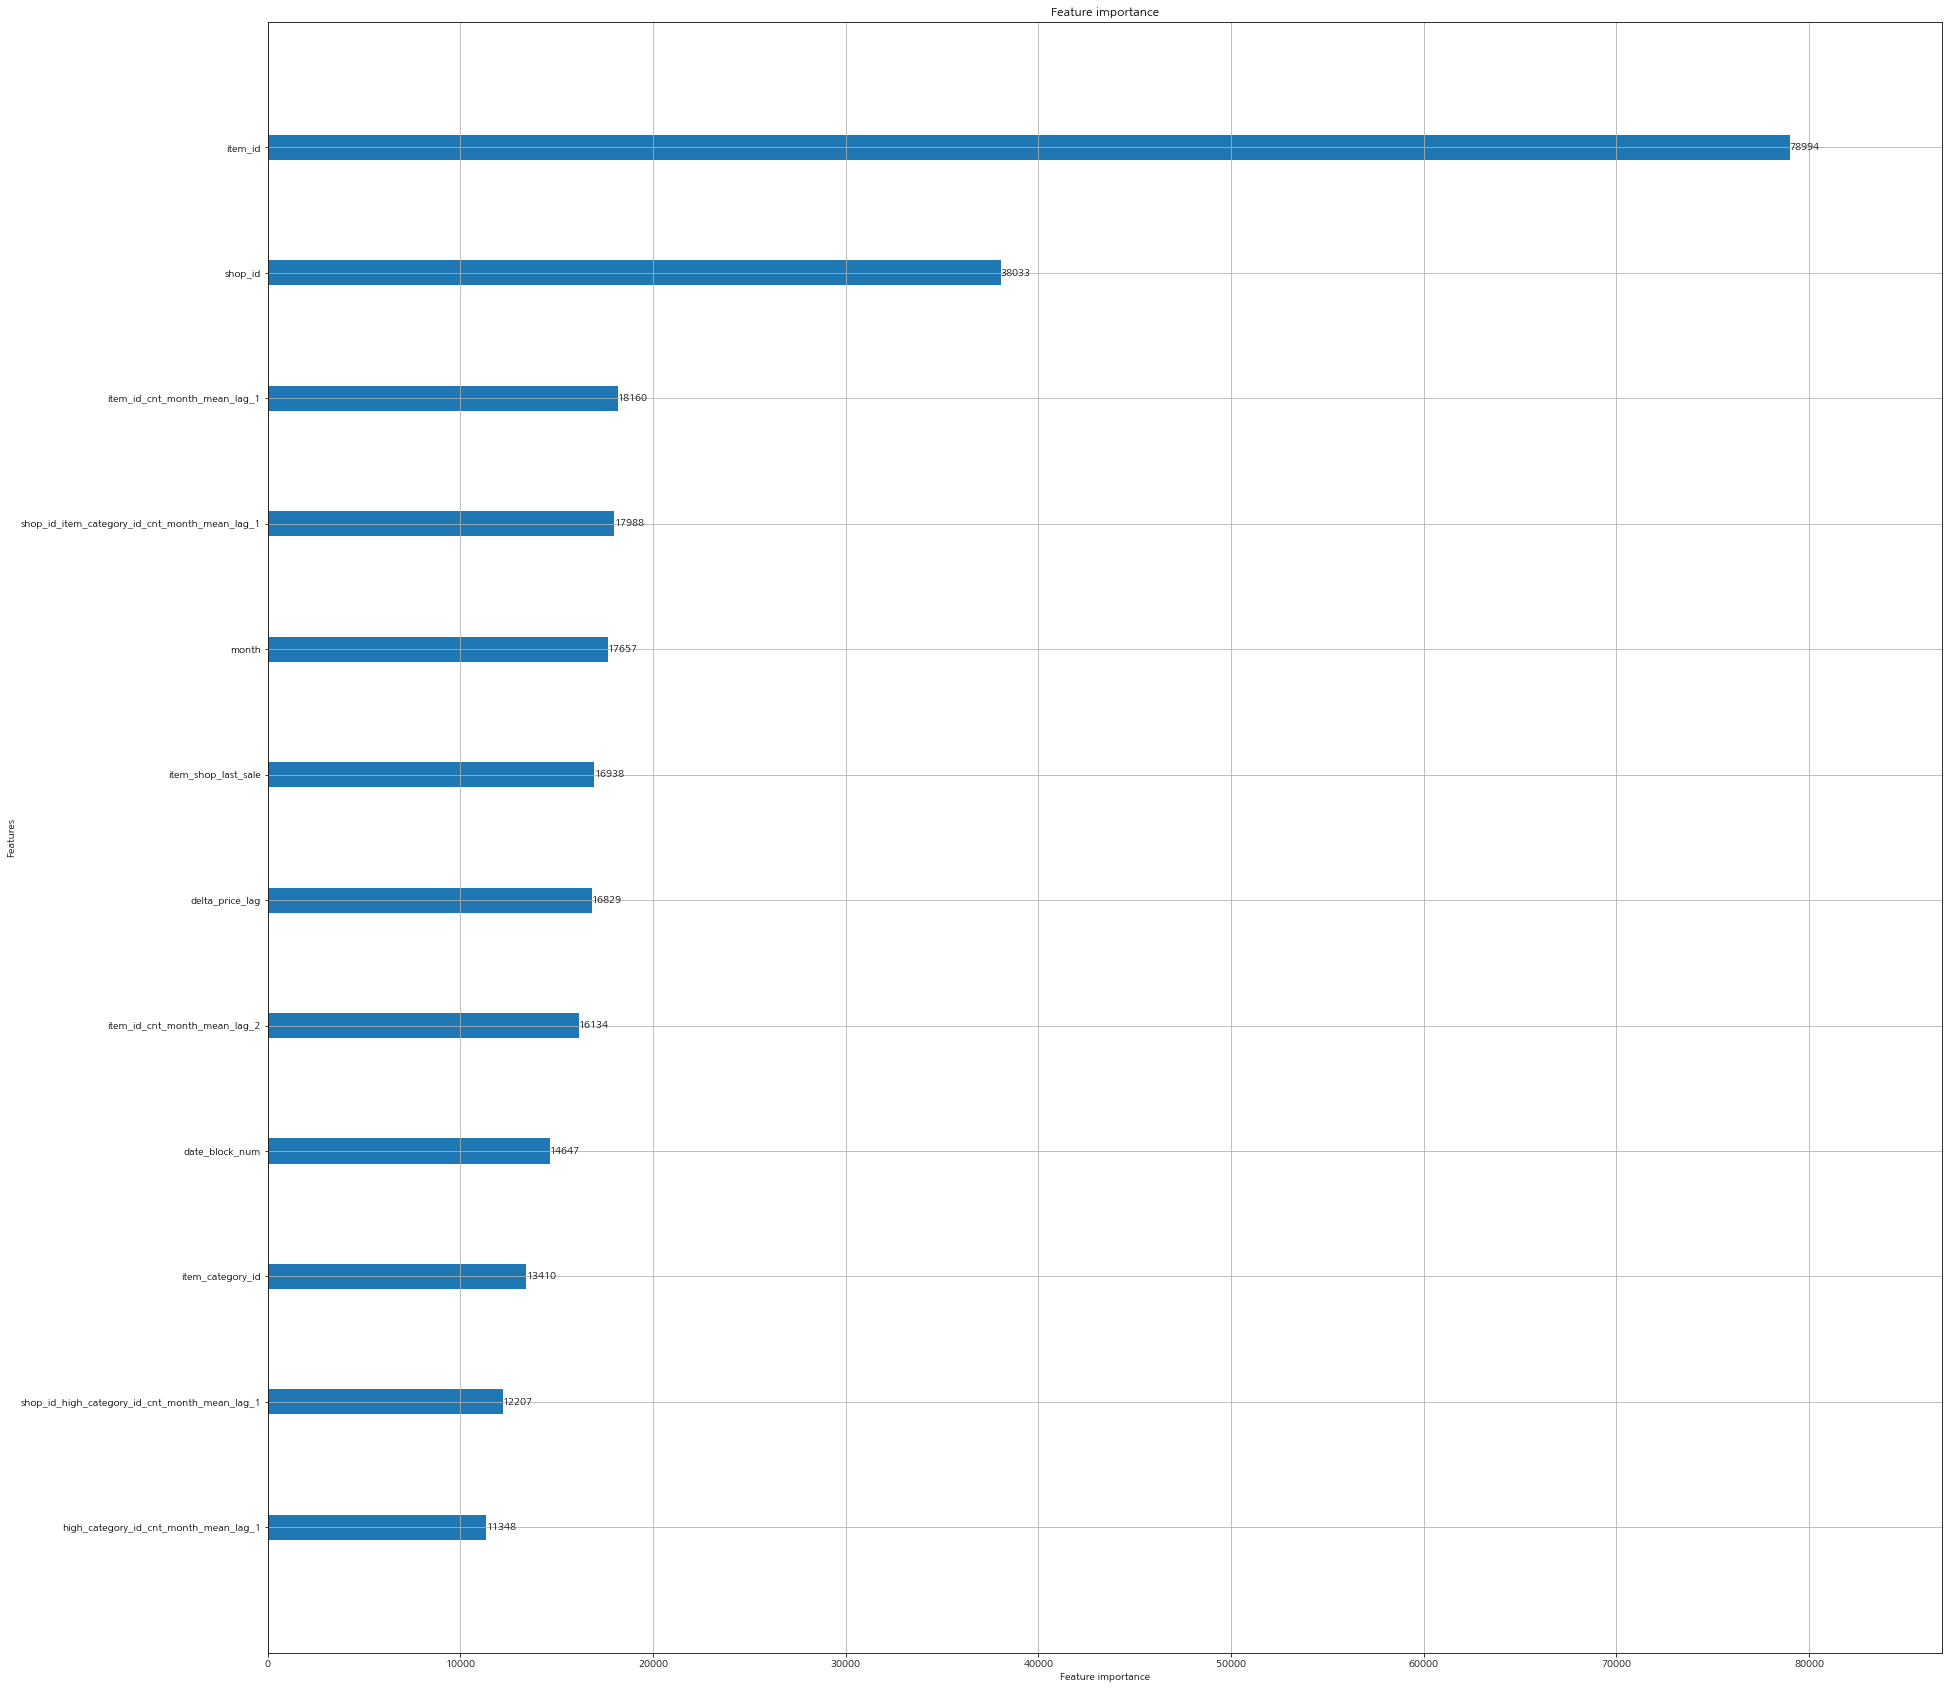

In [304]:
lgb.plot_importance(lgb_model,figsize = (30,30),max_num_features = 12)

In [297]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

C:\Users\AW17R4\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\AW17R4\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.05998	validation_1-rmse:1.04217
[1]	validation_0-rmse:0.96878	validation_1-rmse:0.97728
[2]	validation_0-rmse:0.91682	validation_1-rmse:0.94490
[3]	validation_0-rmse:0.88588	validation_1-rmse:0.92874
[4]	validation_0-rmse:0.86894	validation_1-rmse:0.92118
[5]	validation_0-rmse:0.85712	validation_1-rmse:0.91691
[6]	validation_0-rmse:0.84959	validation_1-rmse:0.91193
[7]	validation_0-rmse:0.84187	validation_1-rmse:0.90691
[8]	validation_0-rmse:0.83703	validation_1-rmse:0.90588
[9]	validation_0-rmse:0.83282	validation_1-rmse:0.90535
[10]	validation_0-rmse:0.82866	validation_1-rmse:0.90599
[11]	validation_0-rmse:0.82541	validation_1-rmse:0.90614
[12]	validation_0-rmse:0.82203	validation_1-rmse:0.90536
[13]	validation_0-rmse:0.81981	validation_1-rmse:0.90488
[14]	validation_0-rmse:0.81797	validation_1-rmse:0.90476
[15]	validation_0-rmse:0.81628	validation_1-rmse:0.90423
[16]	validation_0-rmse:0.81509	validation_1-rmse:0.90440
[17]	validation_0-rmse:0.81409	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=300,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [298]:
pred = model.predict(x_test).clip(0,20)

In [299]:
pred

array([0.19455379, 0.19455379, 0.25011224, ..., 0.21378253, 0.19369863,
       0.19369863], dtype=float32)

In [300]:
submission = pd.DataFrame({
    "ID": test.index, 
    
    "item_cnt_month": preds
})
submission.to_csv('xgb_submission.csv', index=False)  

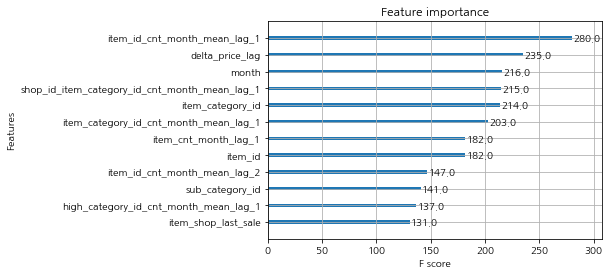

In [301]:
plot_importance(model ,max_num_features = 12)

plt.show()